# irradiance.py tutorial

This tutorial explores some of the functions available in the ``pvlib`` module ``irradiance.py``.

This tutorial requires pvlib >= 0.6.0.

Authors:
* Will Holmgren (@wholmgren), University of Arizona. July 2014, April 2015, July 2015, March 2016, July 2016, February 2017, August 2018.
* Yunho Kee (@yhkee0404), Haezoom. Jun 2024.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
    
# built in python modules
import datetime

# python add-ons
import numpy as np
import pandas as pd

import pvlib

## Table of contents

1. [Extraterrestrial radiation](#Extraterrestrial-radiation)
2. [Clear sky models](#Clear-sky-models)
2. [Diffuse ground](#Diffuse-ground)
2. [Diffuse sky](#Diffuse-sky)
    1. [Isotropic](#Isotropic-model)
    2. [Klucher](#Klucher-model)
    2. [Reindl](#Reindl-model)
    2. [Hay-Davies](#Hay-Davies-model)
    2. [Perez](#Perez-model)
2. [Angle of incidence](#Angle-of-incidence-functions)
2. [total_irrad](#total_irrad)

### Extraterrestrial radiation

Many solar power algorithms start with the irradiance incident on the top of the Earth's atmosphere, often known as the extraterrestrial radiation. ``pvlib`` has four different algorithms to calculate the yearly cycle of the extraterrestrial radiation given the solar constant. As of pvlib 0.4, each method can accept many different input types (day of year, arrays of day of year, datetimes, DatetimeIndex, etc.) and will consistently return the appropriate output type.

In [2]:
# DatetimeIndex in yields a TimeSeries out
times = pd.date_range('2014-01-01', '2015-01-01', freq='1h')

spencer = pvlib.irradiance.get_extra_radiation(times, method='spencer')
asce = pvlib.irradiance.get_extra_radiation(times, method='asce')
ephem = pvlib.irradiance.get_extra_radiation(times, method='pyephem') 
nrel = pvlib.irradiance.get_extra_radiation(times, method='nrel')

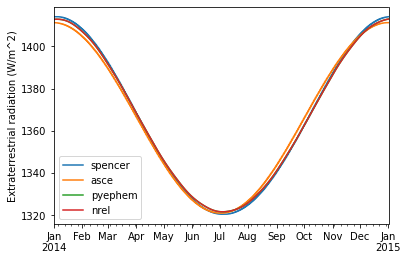

In [3]:
spencer.plot(label='spencer')
asce.plot(label='asce')
ephem.plot(label='pyephem')
nrel.plot(label='nrel')
plt.legend()
plt.ylabel('Extraterrestrial radiation (W/m^2)');

The ``pyephem`` and ``nrel`` methods are the most accurate. However, as shown in the plot below, the difference between them and the spencer method is only +/-2 W/m^2 over the entire year.

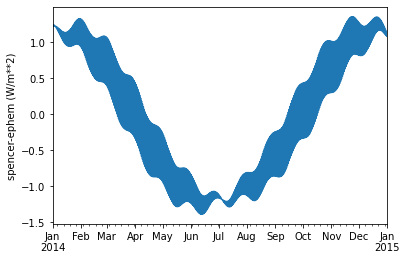

In [4]:
et_diff = spencer - ephem
et_diff.plot()
plt.ylabel('spencer-ephem (W/m**2)');

The intraday squiggles are due to the fact that the asce and spencer methods will cast a DatetimeIndex into integer days of year, while the pyephem and nrel methods also use the time of day.

The difference between the nrel and pyephem methods is negligible.

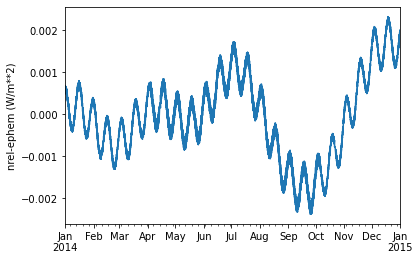

In [5]:
et_diff = nrel - ephem
et_diff.plot()
plt.ylabel('nrel-ephem (W/m**2)');

You can also control the solar constant. Recent literature suggests that the solar constant is 1361 $W/m^2$ rather than the commonly accepted 1367 $W/m^2$.

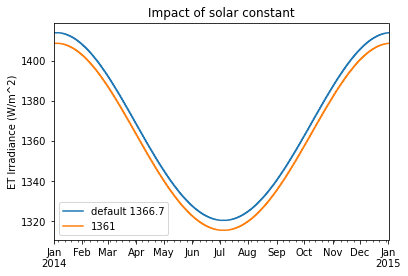

In [6]:
spencer_1361 = pvlib.irradiance.get_extra_radiation(times, method='spencer', solar_constant=1361)

spencer.plot(label='default 1366.7')
spencer_1361.plot(label='1361')
plt.legend()
plt.title('Impact of solar constant')
plt.ylabel('ET Irradiance (W/m^2)');

Compare the time it takes to do the calculations.

In [7]:
times = pd.date_range(start='2015', end='2016', freq='1min')

In [8]:
# NBVAL_SKIP
%timeit spencer = pvlib.irradiance.get_extra_radiation(times, method='spencer')
%timeit asce = pvlib.irradiance.get_extra_radiation(times, method='asce')
%timeit ephem = pvlib.irradiance.get_extra_radiation(times, method='pyephem')
%timeit nrel = pvlib.irradiance.get_extra_radiation(times, method='nrel')
%timeit nrel = pvlib.irradiance.get_extra_radiation(times, method='nrel', how='numba')

102 ms ± 1.49 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
59.9 ms ± 1.09 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
5.24 s ± 21.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.89 s ± 39.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


c:\users\kanderso\software\anaconda3\envs\pvlib-dev\lib\site-packages\pvlib\solarposition.py:265: UserWarning: Reloading spa to use numba
  warnings.warn('Reloading spa to use numba')


152 ms ± 10.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In addition to DatetimeIndex input, the methods also work for various scalar datetime-like formats as well as scalar and array day of year input.

2016-10-26 00:00:00 spencer 1383.6362028955045
2016-10-26 00:00:00 asce 1385.7848051831807
2016-10-26 00:00:00 pyephem 1382.3920240844304
2016-10-26 00:00:00 nrel 1382.3912017480877
2016-10-26 spencer 1383.6362028955045
2016-10-26 asce 1385.7848051831807
2016-10-26 pyephem 1382.3920240844304
2016-10-26 nrel 1382.3912017480877
300 spencer 1383.6362028955045
300 asce 1385.7848051831807
300 pyephem 1382.618664623793
300 nrel 1382.6174658748046


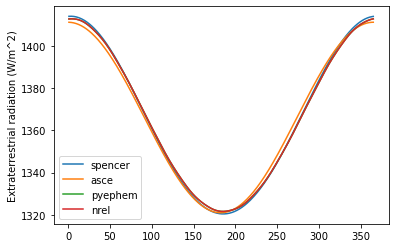

In [9]:
methods = ['spencer', 'asce', 'pyephem', 'nrel']

# pandas timestamp input
times = pd.Timestamp('20161026')
for method in methods:
    dni_extra = pvlib.irradiance.get_extra_radiation(times, method=method)
    assert isinstance(dni_extra, float)
    print(times, method, dni_extra)
    
    
# date input
times = datetime.date(2016, 10, 26)
for method in methods:
    dni_extra = pvlib.irradiance.get_extra_radiation(times, method=method)
    assert isinstance(dni_extra, float)
    print(times, method, dni_extra)
    
    
# integer doy input
times = 300
for method in methods:
    dni_extra = pvlib.irradiance.get_extra_radiation(times, method=method)
    assert isinstance(dni_extra, float)
    print(times, method, dni_extra)
    
    
# array doy input
times = np.arange(1, 366)
for method in methods:
    dni_extra = pvlib.irradiance.get_extra_radiation(times, method=method)
    assert isinstance(dni_extra, np.ndarray)
    plt.plot(times, dni_extra, label=method)
    
plt.legend()
plt.ylabel('Extraterrestrial radiation (W/m^2)');

## Clear sky models

See the online documentation for clear sky modeling examples.

http://pvlib-python.readthedocs.io/en/stable/user_guide/clearsky.html

Here we only generate data for the functions below.

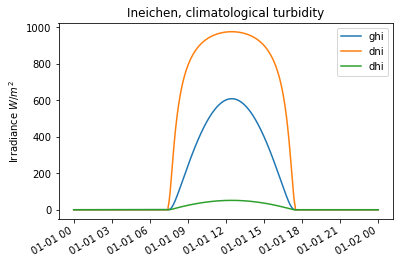

In [10]:
tus = pvlib.location.Location(32.2, -111, 'US/Arizona', 700, 'Tucson')
times = pd.date_range(start='2016-01-01', end='2016-01-02', freq='1min', tz=tus.tz)
times_utc = times.tz_convert('UTC')
ephem_data = tus.get_solarposition(times)
irrad_data = tus.get_clearsky(times)
irrad_data.plot()
plt.ylabel('Irradiance $W/m^2$')
plt.title('Ineichen, climatological turbidity');

## Diffuse ground

The ``grounddiffuse`` function has a few different ways to obtain the diffuse light reflected from the ground given an surface tilt and the GHI.

First, you can specify the albedo of ground.

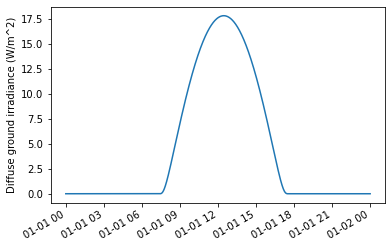

In [11]:
ground_irrad = pvlib.irradiance.get_ground_diffuse(40, irrad_data['ghi'], albedo=.25)
ground_irrad.plot()
plt.ylabel('Diffuse ground irradiance (W/m^2)');

Alternatively, you can specify the surface type with a string such as ``'concrete'`` or ``'snow'``. All of the available ``surface_type`` options are show in the plot below.

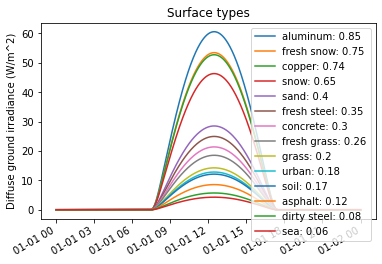

In [12]:
for surface, albedo in sorted(pvlib.irradiance.SURFACE_ALBEDOS.items(), key=lambda x: x[1], reverse=True):
    ground_irrad = pvlib.irradiance.get_ground_diffuse(40, irrad_data['ghi'], surface_type=surface)
    ground_irrad.plot(label='{}: {}'.format(surface, albedo))

plt.legend()
plt.ylabel('Diffuse ground irradiance (W/m^2)')
plt.title('Surface types');

Next, vary the tilt angle. We expect to see maximum ground diffuse irradiance at a 90 deg tilt, and no ground diffuse irradiance at 0 tilt.

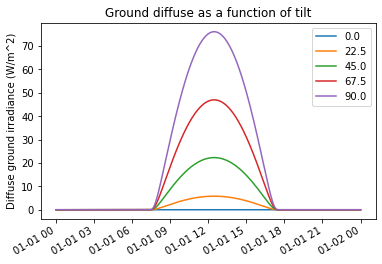

In [13]:
for surf_tilt in np.linspace(0, 90, 5):
    ground_irrad = pvlib.irradiance.get_ground_diffuse(surf_tilt, irrad_data['ghi'])
    ground_irrad.plot(label=surf_tilt)

plt.legend()
plt.ylabel('Diffuse ground irradiance (W/m^2)')
plt.title('Ground diffuse as a function of tilt');

### Diffuse sky

``pvlib`` has many different ways to calculate the diffuse sky component of GHI. 

The API for some of these functions needs some work.

1. [Isotropic](#Isotropic-model)
2. [Klucher](#Klucher-model)
2. [Reindl](#Reindl-model)
2. [Hay-Davies](#Hay-Davies-model)
2. [Perez](#Perez-model)

### Isotropic model

The ``isotropic`` model is the simplest model.

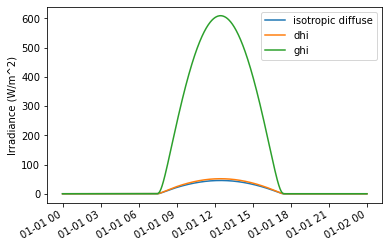

In [14]:
sky_diffuse = pvlib.irradiance.isotropic(40, irrad_data['dhi'])
sky_diffuse.plot(label='isotropic diffuse')
irrad_data['dhi'].plot()
irrad_data['ghi'].plot()
plt.legend()
plt.ylabel('Irradiance (W/m^2)');

Compare just the POA diffuse to the input DHI.

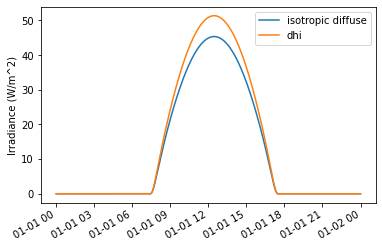

In [15]:
sky_diffuse = pvlib.irradiance.isotropic(40, irrad_data['dhi'])
sky_diffuse.plot(label='isotropic diffuse')
irrad_data['dhi'].plot()
plt.legend()
plt.ylabel('Irradiance (W/m^2)');

### Klucher model

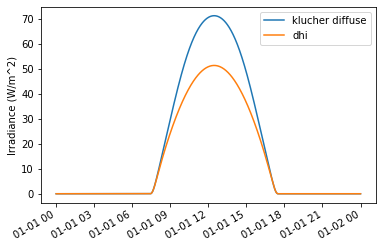

In [16]:
surf_tilt = 40
surf_az = 180

sky_diffuse = pvlib.irradiance.klucher(surf_tilt, surf_az, irrad_data['dhi'], irrad_data['ghi'], 
                                       ephem_data['apparent_zenith'], ephem_data['azimuth'])
sky_diffuse.plot(label='klucher diffuse')
irrad_data['dhi'].plot()
#irrad_data['ghi'].plot()
plt.legend()
plt.ylabel('Irradiance (W/m^2)');

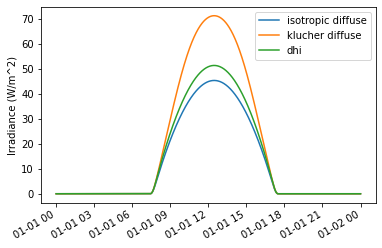

In [17]:
surf_tilt = 40
surf_az = 180 # south facing

iso_diffuse = pvlib.irradiance.isotropic(surf_tilt, irrad_data['dhi'])
iso_diffuse.plot(label='isotropic diffuse')

klucher_diffuse = pvlib.irradiance.klucher(surf_tilt, surf_az, irrad_data['dhi'], irrad_data['ghi'], 
                                        ephem_data['apparent_zenith'], ephem_data['azimuth'])
klucher_diffuse.plot(label='klucher diffuse')

irrad_data['dhi'].plot()

plt.legend()
plt.ylabel('Irradiance (W/m^2)');

Klucher as a function of surface azimuth.

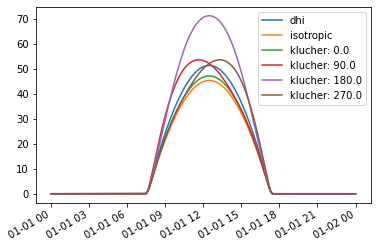

In [18]:
surf_tilt = 40

irrad_data['dhi'].plot()

iso_diffuse = pvlib.irradiance.isotropic(surf_tilt, irrad_data['dhi'])
iso_diffuse.plot(label='isotropic')

for surf_az in np.linspace(0, 270, 4):
    klucher_diffuse = pvlib.irradiance.klucher(surf_tilt, surf_az, irrad_data['dhi'], irrad_data['ghi'], 
                                            ephem_data['apparent_zenith'], ephem_data['azimuth'])
    klucher_diffuse.plot(label='klucher: {}'.format(surf_az))

plt.legend();

Surface azimuth should not matter if tilt is 0.

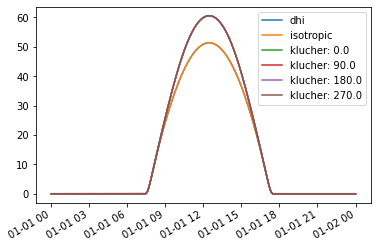

In [19]:
surf_tilt = 0

irrad_data['dhi'].plot()

iso_diffuse = pvlib.irradiance.isotropic(surf_tilt, irrad_data['dhi'])
iso_diffuse.plot(label='isotropic')

for surf_az in np.linspace(0, 270, 4):
    klucher_diffuse = pvlib.irradiance.klucher(surf_tilt, surf_az, irrad_data['dhi'], irrad_data['ghi'], 
                                                ephem_data['apparent_zenith'], ephem_data['azimuth'])
    klucher_diffuse.plot(label='klucher: {}'.format(surf_az))

plt.legend();

### Reindl model

South facing at latitude.

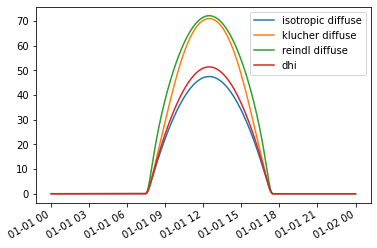

In [20]:
surf_tilt = 32
surf_az = 180 # south facing

iso_diffuse = pvlib.irradiance.isotropic(surf_tilt, irrad_data['dhi'])
iso_diffuse.plot(label='isotropic diffuse')

klucher_diffuse = pvlib.irradiance.klucher(surf_tilt, surf_az, 
                                            irrad_data['dhi'], irrad_data['ghi'], 
                                            ephem_data['apparent_zenith'], ephem_data['azimuth'])
klucher_diffuse.plot(label='klucher diffuse')

dni_et = pvlib.irradiance.get_extra_radiation(times_utc.dayofyear)
reindl_diffuse = pvlib.irradiance.reindl(surf_tilt, surf_az, 
                                          irrad_data['dhi'], irrad_data['dni'], irrad_data['ghi'], dni_et,
                                          ephem_data['apparent_zenith'], ephem_data['azimuth'])
reindl_diffuse.plot(label='reindl diffuse')

irrad_data['dhi'].plot()

plt.legend();

East facing

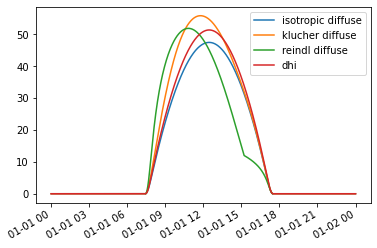

In [21]:
surf_tilt = 32
surf_az = 90 

iso_diffuse = pvlib.irradiance.isotropic(surf_tilt, irrad_data['dhi'])
iso_diffuse.plot(label='isotropic diffuse')

klucher_diffuse = pvlib.irradiance.klucher(surf_tilt, surf_az, 
                                            irrad_data['dhi'], irrad_data['ghi'], 
                                            ephem_data['apparent_zenith'], ephem_data['azimuth'])
klucher_diffuse.plot(label='klucher diffuse')

dni_et = pvlib.irradiance.get_extra_radiation(times_utc.dayofyear)
reindl_diffuse = pvlib.irradiance.reindl(surf_tilt, surf_az, 
                                          irrad_data['dhi'], irrad_data['dni'], irrad_data['ghi'], dni_et,
                                          ephem_data['apparent_zenith'], ephem_data['azimuth'])
reindl_diffuse.plot(label='reindl diffuse')

irrad_data['dhi'].plot()

plt.legend();

### Hay-Davies model

Hay-Davies facing south.

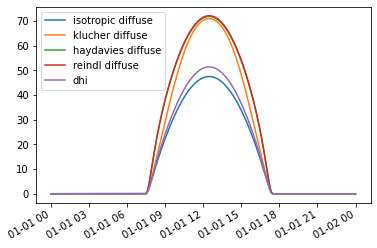

In [22]:
surf_tilt = 32
surf_az = 180 

iso_diffuse = pvlib.irradiance.isotropic(surf_tilt, irrad_data['dhi'])
iso_diffuse.plot(label='isotropic diffuse')

klucher_diffuse = pvlib.irradiance.klucher(surf_tilt, surf_az, 
                                            irrad_data['dhi'], irrad_data['ghi'], 
                                            ephem_data['apparent_zenith'], ephem_data['azimuth'])
klucher_diffuse.plot(label='klucher diffuse')

dni_et = pvlib.irradiance.get_extra_radiation(times_utc.dayofyear)

haydavies_diffuse = pvlib.irradiance.haydavies(surf_tilt, surf_az, 
                                                irrad_data['dhi'], irrad_data['dni'], dni_et,
                                                ephem_data['apparent_zenith'], ephem_data['azimuth'])
haydavies_diffuse.plot(label='haydavies diffuse')

reindl_diffuse = pvlib.irradiance.reindl(surf_tilt, surf_az, 
                                          irrad_data['dhi'], irrad_data['dni'], irrad_data['ghi'], dni_et,
                                          ephem_data['apparent_zenith'], ephem_data['azimuth'])
reindl_diffuse.plot(label='reindl diffuse')

irrad_data['dhi'].plot()

plt.legend();

Facing east.

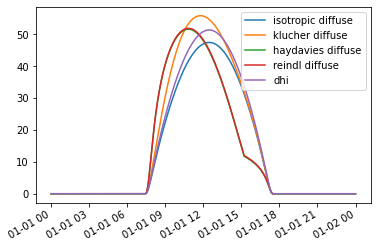

In [23]:
surf_tilt = 32
surf_az = 90 

iso_diffuse = pvlib.irradiance.isotropic(surf_tilt, irrad_data['dhi'])
iso_diffuse.plot(label='isotropic diffuse')

klucher_diffuse = pvlib.irradiance.klucher(surf_tilt, surf_az, 
                                            irrad_data['dhi'], irrad_data['ghi'], 
                                            ephem_data['apparent_zenith'], ephem_data['azimuth'])
klucher_diffuse.plot(label='klucher diffuse')

dni_et = pvlib.irradiance.get_extra_radiation(times_utc.dayofyear)

haydavies_diffuse = pvlib.irradiance.haydavies(surf_tilt, surf_az, 
                                                irrad_data['dhi'], irrad_data['dni'], dni_et,
                                                ephem_data['apparent_zenith'], ephem_data['azimuth'])
haydavies_diffuse.plot(label='haydavies diffuse')

reindl_diffuse = pvlib.irradiance.reindl(surf_tilt, surf_az, 
                                          irrad_data['dhi'], irrad_data['dni'], irrad_data['ghi'], dni_et,
                                          ephem_data['apparent_zenith'], ephem_data['azimuth'])
reindl_diffuse.plot(label='reindl diffuse')

irrad_data['dhi'].plot()

plt.legend();

Hay-Davies appears to be very similar to Reindl. Too similar?

### King model

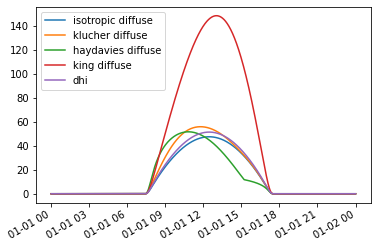

In [24]:
surf_tilt = 32
surf_az = 90 

iso_diffuse = pvlib.irradiance.isotropic(surf_tilt, irrad_data['dhi'])
iso_diffuse.plot(label='isotropic diffuse')

klucher_diffuse = pvlib.irradiance.klucher(surf_tilt, surf_az, 
                                            irrad_data['dhi'], irrad_data['ghi'], 
                                            ephem_data['apparent_zenith'], ephem_data['azimuth'])
klucher_diffuse.plot(label='klucher diffuse')

dni_et = pvlib.irradiance.get_extra_radiation(times_utc.dayofyear)

haydavies_diffuse = pvlib.irradiance.haydavies(surf_tilt, surf_az, 
                                                irrad_data['dhi'], irrad_data['dni'], dni_et,
                                                ephem_data['apparent_zenith'], ephem_data['azimuth'])
haydavies_diffuse.plot(label='haydavies diffuse')

king_diffuse = pvlib.irradiance.king(surf_tilt,irrad_data['dhi'], irrad_data['ghi'], ephem_data['azimuth'])
king_diffuse.plot(label='king diffuse')

irrad_data['dhi'].plot()

plt.legend();

### Perez model

This section walks through the Perez algorithm.

In [25]:
sun_zen = ephem_data['apparent_zenith']
sun_az = ephem_data['azimuth']
DNI = irrad_data['dni']
DHI = irrad_data['dhi']
DNI_ET = pvlib.irradiance.get_extra_radiation(times_utc.dayofyear)
AM = pvlib.atmosphere.get_relative_airmass(sun_zen)

surf_tilt = 32
surf_az = 180

kappa = 1.041 #for sun_zen in radians
z = np.radians(sun_zen) # convert to radians

#Dhfilter = DHI > 0

# epsilon is the sky's clearness
eps = ( (DHI + DNI)/DHI + kappa*(z**3) ) / ( 1 + kappa*(z**3) )

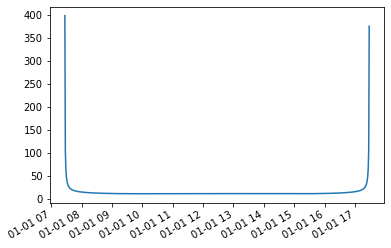

In [26]:
eps.plot();

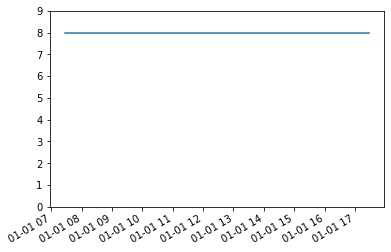

In [27]:
ebin = eps.copy()
ebin[(eps<1.065)] = 1
ebin[(eps>=1.065) & (eps<1.23)] = 2
ebin[(eps>=1.23) & (eps<1.5)] = 3
ebin[(eps>=1.5) & (eps<1.95)] = 4
ebin[(eps>=1.95) & (eps<2.8)] = 5
ebin[(eps>=2.8) & (eps<4.5)] = 6
ebin[(eps>=4.5) & (eps<6.2)] = 7
ebin[eps>=6.2] = 8

ebin.plot()
plt.ylim(0,9);

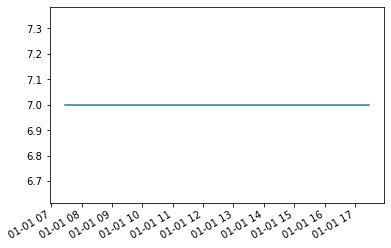

In [28]:
ebin = ebin - 1
ebin = ebin.dropna().astype(int)
ebin.plot();

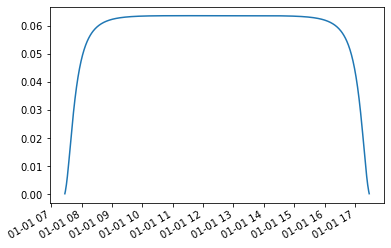

In [29]:
delta = DHI * AM / DNI_ET
delta.plot();

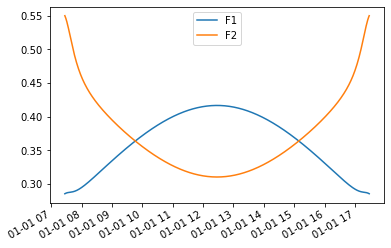

In [30]:
modelt = 'allsitescomposite1990'

F1c, F2c = pvlib.irradiance._get_perez_coefficients(modelt)

F1 = F1c[ebin,0] + F1c[ebin,1]*delta[ebin.index] + F1c[ebin,2]*z[ebin.index]
F1[F1<0]=0;
F1=F1.astype(float)

#F2= F2c[ebin,0] + F2c[ebin,1]*delta[ebinfilter] + F2c[ebin,2]*z[ebinfilter]
F2= F2c[ebin,0] + F2c[ebin,1]*delta[ebin.index] + F2c[ebin,2]*z[ebin.index]
F2[F2<0]=0
F2=F2.astype(float)

F1.plot(label='F1')
F2.plot(label='F2')
plt.legend();

In [31]:
from pvlib import tools

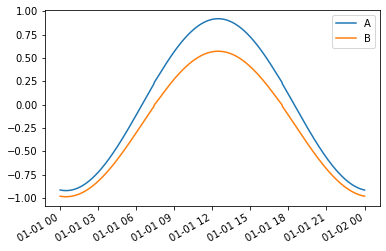

In [32]:
A = tools.cosd(surf_tilt)*tools.cosd(sun_zen) + tools.sind(surf_tilt)*tools.sind(sun_zen)*tools.cosd(sun_az-surf_az) #removed +180 from azimuth modifier: Rob Andrews October 19th 2012
#A[A < 0] = 0

B = tools.cosd(sun_zen);
#B[B < pvl_tools.cosd(85)] = pvl_tools.cosd(85)

A.plot(label='A')
B.plot(label='B')
plt.legend();

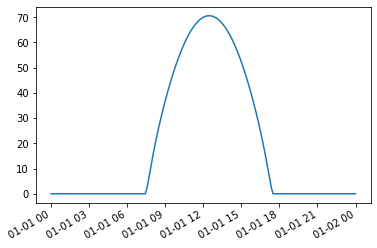

In [33]:
sky_diffuse = DHI*( 0.5* (1-F1)*(1+tools.cosd(surf_tilt))+F1 * A[ebin.index]/ B[ebin.index] + F2*tools.sind(surf_tilt))
sky_diffuse[sky_diffuse < 0] = 0
sky_diffuse[AM.isnull()] = 0

sky_diffuse.plot();

Compare the Perez model to others.

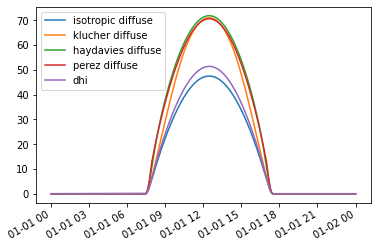

In [34]:
sun_zen = ephem_data['apparent_zenith']
sun_az = ephem_data['azimuth']
DNI = irrad_data['dni']
DHI = irrad_data['dhi']
DNI_ET = pvlib.irradiance.get_extra_radiation(times_utc.dayofyear)
AM = pvlib.atmosphere.get_relative_airmass(sun_zen)

surf_tilt = 32
surf_az = 180

iso_diffuse = pvlib.irradiance.isotropic(surf_tilt, irrad_data['dhi'])
iso_diffuse.plot(label='isotropic diffuse')

klucher_diffuse = pvlib.irradiance.klucher(surf_tilt, surf_az, 
                                            irrad_data['dhi'], irrad_data['ghi'], 
                                            ephem_data['apparent_zenith'], ephem_data['azimuth'])
klucher_diffuse.plot(label='klucher diffuse')

dni_et = pvlib.irradiance.get_extra_radiation(times_utc.dayofyear)

haydavies_diffuse = pvlib.irradiance.haydavies(surf_tilt, surf_az, 
                                                irrad_data['dhi'], irrad_data['dni'], dni_et,
                                                ephem_data['apparent_zenith'], ephem_data['azimuth'])
haydavies_diffuse.plot(label='haydavies diffuse')

perez_diffuse = pvlib.irradiance.perez(surf_tilt, surf_az, 
                                        irrad_data['dhi'], irrad_data['dni'], dni_et,
                                        ephem_data['apparent_zenith'], ephem_data['azimuth'],
                                        AM)
perez_diffuse.plot(label='perez diffuse')

irrad_data['dhi'].plot()

plt.legend();

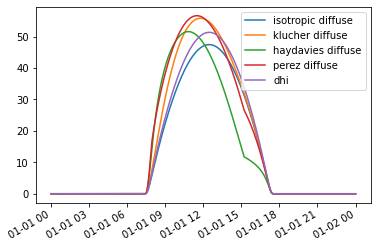

In [35]:
sun_zen = ephem_data['apparent_zenith']
sun_az = ephem_data['azimuth']
DNI = irrad_data['dni']
DHI = irrad_data['dhi']
DNI_ET = pvlib.irradiance.get_extra_radiation(times_utc.dayofyear)
AM = pvlib.atmosphere.get_relative_airmass(sun_zen)

surf_tilt = 32
surf_az = 90

iso_diffuse = pvlib.irradiance.isotropic(surf_tilt, irrad_data['dhi'])
iso_diffuse.plot(label='isotropic diffuse')

klucher_diffuse = pvlib.irradiance.klucher(surf_tilt, surf_az, 
                                            irrad_data['dhi'], irrad_data['ghi'], 
                                            ephem_data['apparent_zenith'], ephem_data['azimuth'])
klucher_diffuse.plot(label='klucher diffuse')

dni_et = pvlib.irradiance.get_extra_radiation(times_utc.dayofyear)

haydavies_diffuse = pvlib.irradiance.haydavies(surf_tilt, surf_az, 
                                                irrad_data['dhi'], irrad_data['dni'], dni_et,
                                                ephem_data['apparent_zenith'], ephem_data['azimuth'])
haydavies_diffuse.plot(label='haydavies diffuse')

perez_diffuse = pvlib.irradiance.perez(surf_tilt, surf_az, 
                                        irrad_data['dhi'], irrad_data['dni'], dni_et,
                                        ephem_data['apparent_zenith'], ephem_data['azimuth'],
                                        AM)
perez_diffuse.plot(label='perez diffuse')

irrad_data['dhi'].plot()

plt.legend();

Examine the impact of the coeffecient selection.

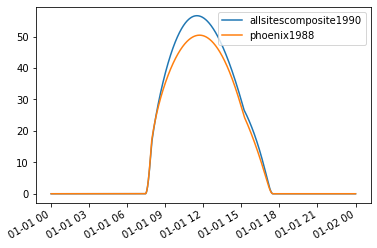

In [36]:
perez_diffuse = pvlib.irradiance.perez(surf_tilt, surf_az, 
                                        irrad_data['dhi'], irrad_data['dni'], dni_et,
                                        ephem_data['apparent_zenith'], ephem_data['azimuth'],
                                        AM, model='allsitescomposite1990')
perez_diffuse.plot(label='allsitescomposite1990')

perez_diffuse = pvlib.irradiance.perez(surf_tilt, surf_az, 
                                        irrad_data['dhi'], irrad_data['dni'], dni_et,
                                        ephem_data['apparent_zenith'], ephem_data['azimuth'],
                                        AM, model='phoenix1988')
perez_diffuse.plot(label='phoenix1988')

plt.legend();

## Angle of incidence functions

The ``irradiance`` module has some convenience functions to help calculate the angle of incidence.

First, the angle of incidence.

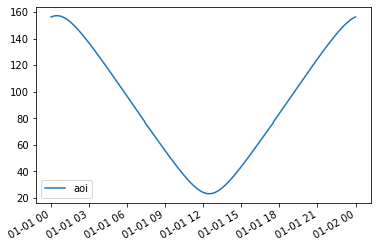

In [37]:
proj = pvlib.irradiance.aoi(32, 180, ephem_data['apparent_zenith'], ephem_data['azimuth'])
proj.plot()

#plt.ylim(-1.1,1.1)
plt.legend();

AOI projection: the dot production of the surface normal and the vector to the sun.

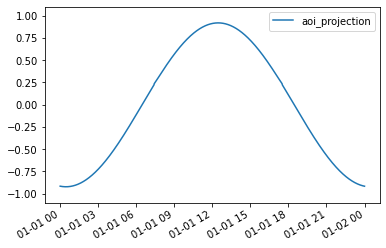

In [38]:
proj = pvlib.irradiance.aoi_projection(32, 180, ephem_data['apparent_zenith'], ephem_data['azimuth'])
proj.plot()

plt.ylim(-1.1,1.1)
plt.legend();

This plot shows that an explicit dot product calculation gives the same result as ``aoi_projection``.

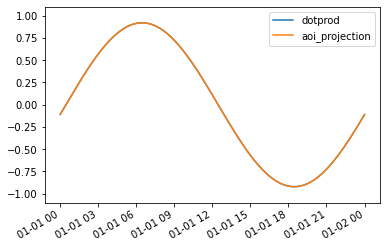

In [40]:
surf_tilt = 90
surf_az = 90

sen_alt_rad = np.radians(90 - surf_tilt)
sen_azi_rad = np.radians(surf_az)

alts = np.radians(90 - ephem_data['apparent_zenith'])
azis = np.radians(ephem_data['azimuth'])

dotprod = np.cos(sen_alt_rad)*np.cos(alts)*np.cos(sen_azi_rad-azis) + np.sin(sen_alt_rad)*np.sin(alts)
dotprod.plot(label='dotprod')

proj = pvlib.irradiance.aoi_projection(surf_tilt, surf_az, ephem_data['apparent_zenith'], ephem_data['azimuth'])
proj.plot()

plt.ylim(-1.1,1.1)
plt.legend();

### get_total_irradiance

There is a convenience function ``get_total_irradiance`` that aims to make it easier to play with different models. For now, we use it to make summary plots of the models explored above.

South facing with latitude tilt.

In [41]:
def get_total_irradiance_per_model(surface_tilt, surface_azimuth):
    models = ['isotropic', 'klucher', 'haydavies', 'reindl', 'king', 'perez']
    totals = {}

    for model in models:
        total = pvlib.irradiance.get_total_irradiance(
            surface_tilt, surface_azimuth,
            ephem_data['apparent_zenith'], ephem_data['azimuth'],
            dni=irrad_data['dni'], ghi=irrad_data['ghi'], dhi=irrad_data['dhi'],
            dni_extra=dni_et, airmass=AM,
            model=model,
            surface_type='urban')
        totals[model] = total
        total.plot()
        plt.title(model)
        plt.ylim(-50, 1100)
        plt.ylabel('Irradiance (W/m^2)')

    plt.figure()
    for model, total in totals.items():
        total['poa_global'].plot(lw=.5, label=model)

    plt.legend()
    plt.ylabel('Irradiance (W/m^2)')

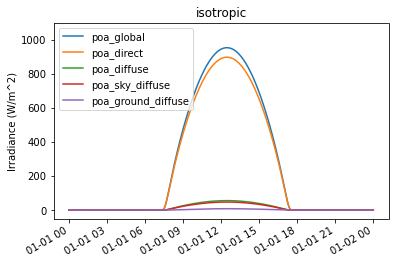

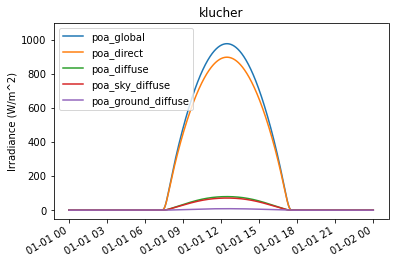

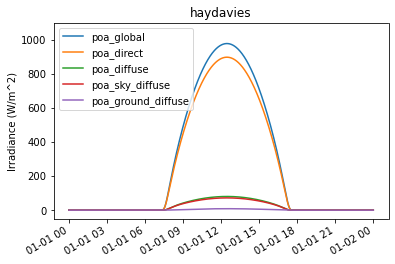

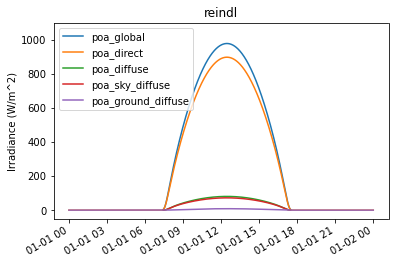

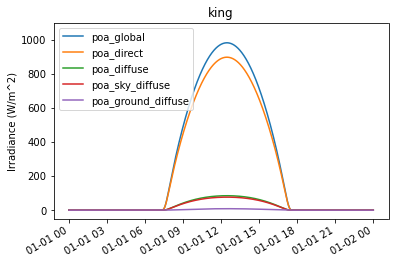

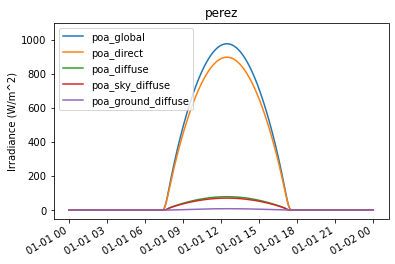

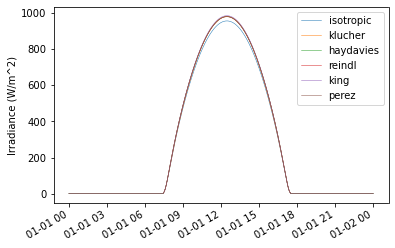

In [42]:
get_total_irradiance_per_model(32, 180)

tilt = 0

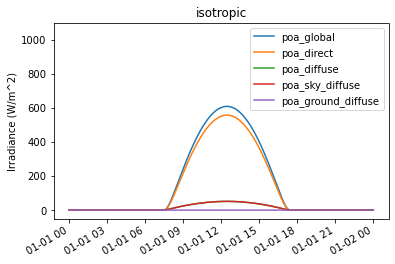

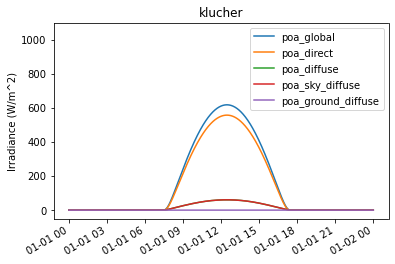

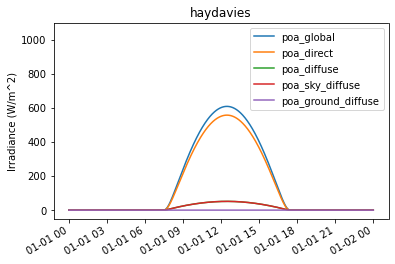

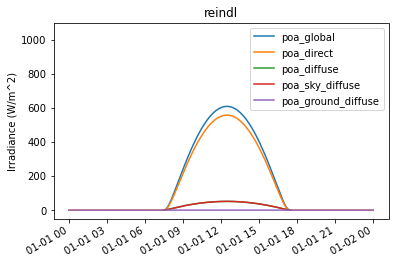

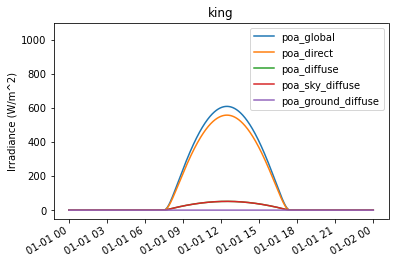

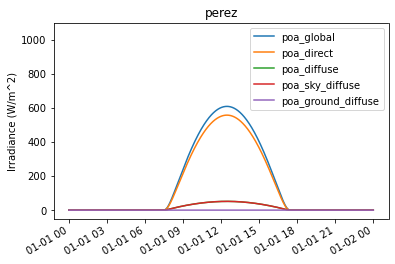

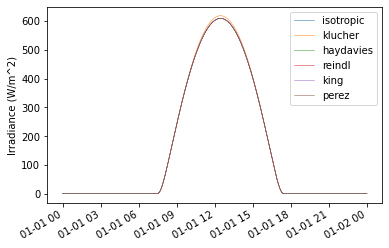

In [43]:
get_total_irradiance_per_model(0, 180)

East facing with latitude tilt.

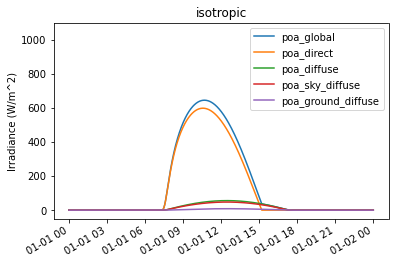

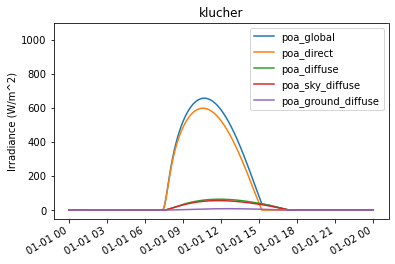

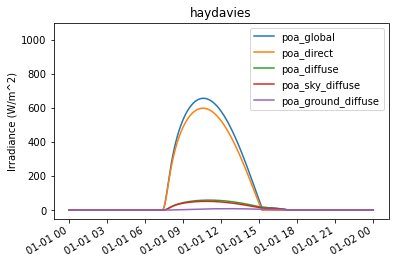

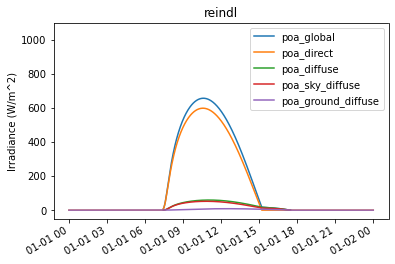

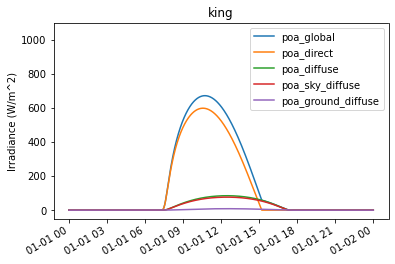

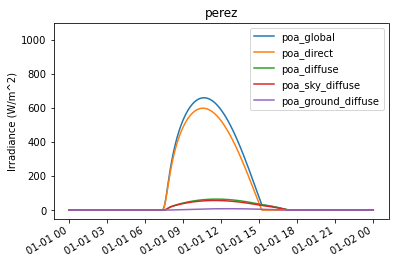

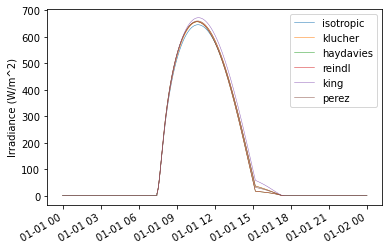

In [44]:
get_total_irradiance_per_model(32, 90)